### Imports

In [75]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

### Download the dataset

In [76]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

In [77]:
# inversion 
invert = lambda image : 255 - image # function to invert the image

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

### Prepare the data

In [78]:
def generate_labels(dataset_images,image_type):
  labels = np.full(shape=(dataset_images.shape[0]),fill_value=[image_type])
  return labels

def binarize(dataset_images):
  result = np.copy(dataset_images)
  for i in range(result.shape[0]):
    for j in range(result.shape[1]):
      for k in range(result.shape[2]):
        if result[i][j][k] > 127:
          result[i][j][k] = 1
        else:
          result[i][j][k] = 0
  return result

# function for inverting data
def get_inverted_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    original_images = invert(source_dataset_images[image_indices]) # get the original images and invert them
    target_dataset = np.concatenate((target_dataset,original_images)) # concatenate to our training dataset
    return target_dataset

# function to prepare training data for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_images_positive = binarize(dataset_images_positive) # binarize the images 
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
    # print(f"Positive train data shape: {dataset_images_positive.shape}")
    # get the images for making negative dataset
    dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = get_inverted_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    dataset_images_negative = binarize(dataset_images_negative) # binarize the images 
    dataset_labels_negative = generate_labels(dataset_images_negative,1) # generate the class labels
    # print(f"Negative train data shape: {dataset_images_negative.shape}")
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    return modified_dataset_images,modified_dataset_labels

# test dataset where given class is positive and all other classes are negative
def prepare_testing_data(dataset_images,dataset_labels,class_num):
  positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
  positive_indices = positive_indices.flatten()
  # get the images for making positive dataset
  dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
  dataset_images_positive = binarize(dataset_images_positive)
  dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
  # print(f"Positive test data shape: {dataset_images_positive.shape}")
  # get the images for making negative classes for testing
  negative_indices = np.asarray(np.where(((dataset_labels != class_num))))
  negative_indices = negative_indices.flatten()
  # get the images for making negative dataset
  dataset_images_negative = dataset_images[negative_indices]
  dataset_images_negative = binarize(dataset_images_negative)
  dataset_labels_negative = generate_labels(dataset_images_negative,1)
  # print(f"Negative test data shape: {dataset_images_negative.shape}")
  # concatenate the negative and positive datasets
  modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
  modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
  return modified_dataset_images,modified_dataset_labels

### Get training and test data

In [79]:
class_num = 0 # target digit
trainX,trainy = prepare_training_data(train_images,train_labels,class_num)
testX,testy = prepare_testing_data(test_images,test_labels,class_num)

### Plot train set

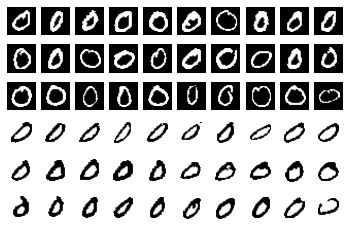

In [80]:
num_of_images = 30
# plot positive class
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(trainX[index].squeeze(),cmap='gray')

# plot negative class
for index in range(1,num_of_images+1):
    plt.subplot(6,10,30+index)
    plt.axis('off')
    plt.imshow(trainX[-index].squeeze(),cmap='gray')

### Plot test set

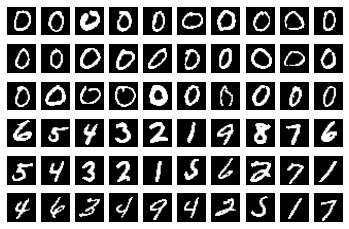

In [81]:
num_of_images = 30
# plot positive class
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(testX[index].squeeze(),cmap='gray')

# plot negative class
for index in range(1,num_of_images+1):
    plt.subplot(6,10,30+index)
    plt.axis('off')
    plt.imshow(testX[-index].squeeze(),cmap='gray')

### Find patterns

In [82]:
patterns = np.empty((0,28,28),dtype=np.float32)
antipatterns = np.empty((0,28,28),dtype=np.float32)

positive_image_indices = [i for i in range(trainX.shape[0]) if trainy[i] == 0]
positive_image = trainX[positive_image_indices[0]]
patterns = np.vstack((patterns,[positive_image])) # store a pattern image
antipatterns = np.vstack((antipatterns,[1-positive_image])) # store an antipattern image

### Plot patterns

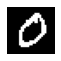

In [83]:
for i in range(patterns.shape[0]):
  if i+1 > 16:
    break
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(patterns[i].squeeze(),cmap='gray')


### Testing the model

In [84]:
def test(X,y,thresh=0):
  y_pred = []
  y_true = []
  for i in range(X.shape[0]):
    image,label = X[i],y[i]
    cnt = 0
    for j in range(patterns.shape[0]):
      yes_score = np.sum(patterns[j] * image)
      no_score = np.sum(antipatterns[j] * image)
      cnt += ((yes_score - no_score) >= thresh)
    
    if cnt >= 1:
      y_pred.append(0)
    else:
      y_pred.append(1)
    y_true.append(label)
  
  return y_true,y_pred

### Train set results

In [85]:
# for thresh in range(30,52,2):
y_train_true,y_train_pred = test(trainX,trainy,0)
print("#######################################################################")
print(f"On Training set for threshold: {0}")
print(f"Accuracy of model: {accuracy_score(y_train_true,y_train_pred)}")
print(f"Precision score: {precision_score(y_train_true,y_train_pred,pos_label=0)}")
print(f"Recall score: {recall_score(y_train_true,y_train_pred,pos_label=0)}")
print(f"F1 score: {f1_score(y_train_true,y_train_pred,pos_label=0)}")
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(y_train_true)):
  if y_train_true[i] == 0:
    if y_train_pred[i] == 1:
      fn += 1
    else:
      tp += 1
  else:
    if y_train_pred[i] == 0:
      fp += 1
    else:
      tn += 1

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")
print("#######################################################################")

#######################################################################
On Training set for threshold: 0
Accuracy of model: 0.8502448083741347
Precision score: 1.0
Recall score: 0.7004896167482695
F1 score: 0.823868149324861
True positives: 4149
False positives: 0
True negatives: 5923
False negatives: 1774
#######################################################################


### Test set results

In [86]:
y_test_true,y_test_pred = test(testX,testy,0)
print(f"On Testing set for threshold: {0}")
print(f"Accuracy of model: {accuracy_score(y_test_true,y_test_pred)}")
print(f"Precision score: {precision_score(y_test_true,y_test_pred,pos_label=0)}")
print(f"Recall score: {recall_score(y_test_true,y_test_pred,pos_label=0)}")
print(f"F1 score: {f1_score(y_test_true,y_test_pred,pos_label=0)}")
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(y_test_true)):
  if y_test_true[i] == 0:
    if y_test_pred[i] == 1:
      fn += 1
    else:
      tp += 1
  else:
    if y_test_pred[i] == 0:
      fp += 1
    else:
      tn += 1

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}")

On Testing set for threshold: 0
Accuracy of model: 0.9036
Precision score: 0.5057553956834533
Recall score: 0.7173469387755103
F1 score: 0.5932489451476793
True positives: 703
False positives: 687
True negatives: 8333
False negatives: 277
